# RSI線交易策略教學
Author：余慶龍  
Establish Date：2021.8.5 
Last Modified Date：2021.8.5

## Table of Contents
1. 介紹MACD指標
2. 讀入股票資料  
3. 計算MACD線
4. 繪出MACD線與股價圖  
5. 策略1：超買超賣區
    1. 策略介紹  
    2. 策略買賣信號
    3. 繪製交易點
    4. 回溯檢驗
6. 策略2：
    1. 策略介紹  
    2. 策略買賣信號
    3. 繪製交易點
    4. 回溯檢驗

額外參考資料

# 1. 介紹MACD指標


## 2. 讀入股票資料

In [1]:
import pandas as pd
import numpy as np

file = "../../parse_data/data/splited/0050.csv"
ticker = pd.read_csv(file)

# change the name of columns
ticker.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# set the column "Date" to index
ticker = ticker.set_index('Date')

# set index column("Date") from string to datetime.datetime
ticker.index = pd.to_datetime(ticker.index)

# sort index column("Date") chronologically
ticker = ticker.sort_index()

# take latest 300 price data for analysis
ticker = ticker.tail(300)
print(ticker)

              Open    High     Low   Close  Volume
Date                                              
2019-12-27   97.60   98.15   97.60   98.00    2978
2019-12-30   98.00   98.25   97.60   97.80    3138
2019-12-31   97.10   97.20   96.95   96.95    4303
2020-01-02   97.05   98.00   97.05   97.65    4882
2020-01-03   98.30   98.70   97.00   97.65    6813
...            ...     ...     ...     ...     ...
2021-03-22  132.40  133.60  131.60  133.40    5510
2021-03-23  133.90  134.70  133.60  133.60    6994
2021-03-24  131.80  132.45  131.30  131.50   11082
2021-03-25  131.10  132.55  130.60  131.95    5186
2021-03-26  133.05  134.40  132.55  134.35    8134

[300 rows x 5 columns]


## 3. 計算MACD線

In [22]:
# Define constants
MACD_N = 9
MACD_EMA_SLOW = 26
MACD_EMA_QUICK = 12
middle_line = 0

# Create a empty dataFrame with original index
# To store some temporary data
tmp = pd.DataFrame(index=ticker.index)

# Copy a dataFrame to store result
# deep=True means make a copy instead of link
data = ticker.copy(deep=True)

tmp['ema12'] = data['Close'].ewm(span=MACD_EMA_QUICK, adjust=False).mean() # exponential moving average
tmp['ema26'] = data['Close'].ewm(span=MACD_EMA_SLOW, adjust=False).mean() # exponential moving average
print(tmp.head(10))

data['macd_DIF']  = tmp['ema12'] - tmp['ema26']                             # qucik MACD
data['macd_DEM'] = data['macd_DIF'].ewm(span = MACD_N, adjust=False).mean()# slow MACD
data['macd_BAR'] = data['macd_DIF'] - data['macd_DEM']                     # MACD bar
print(data.head(10))

                ema12      ema26
Date                            
2019-12-27  98.000000  98.000000
2019-12-30  97.969231  97.985185
2019-12-31  97.812426  97.908505
2020-01-02  97.787437  97.889356
2020-01-03  97.766293  97.871626
2020-01-06  97.556094  97.762617
2020-01-07  97.332080  97.639460
2020-01-08  97.073298  97.492093
2020-01-09  97.054329  97.451938
2020-01-10  97.092125  97.440683
             Open   High    Low  Close  Volume  macd_DIF  macd_DEM  macd_BAR
Date                                                                        
2019-12-27  97.60  98.15  97.60  98.00    2978  0.000000  0.000000  0.000000
2019-12-30  98.00  98.25  97.60  97.80    3138 -0.015954 -0.003191 -0.012764
2019-12-31  97.10  97.20  96.95  96.95    4303 -0.096079 -0.021768 -0.074310
2020-01-02  97.05  98.00  97.05  97.65    4882 -0.101919 -0.037799 -0.064120
2020-01-03  98.30  98.70  97.00  97.65    6813 -0.105333 -0.051305 -0.054028
2020-01-06  97.05  97.10  96.40  96.40    9321 -0.206523 -0.08234

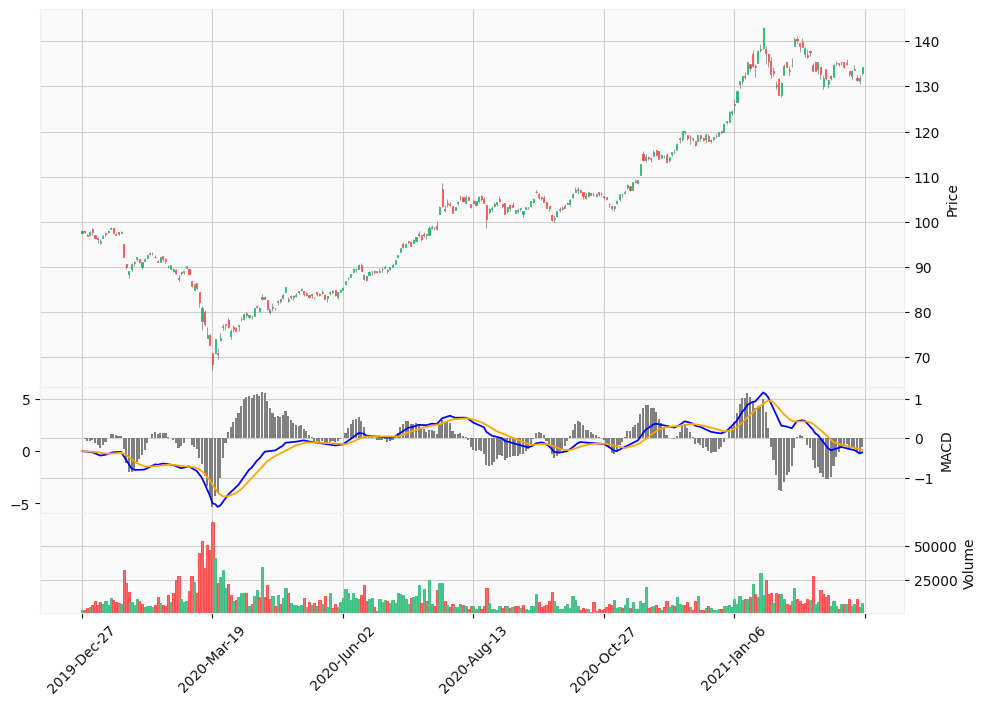

In [23]:
import mplfinance as mpf

plots = [
          mpf.make_addplot(data['macd_BAR'], type = 'bar', panel = 1, color = 'grey', ylabel = 'MACD'),
          mpf.make_addplot(data['macd_DIF'], panel = 1, color = 'blue'),
          mpf.make_addplot(data['macd_DEM'], panel = 1, color = 'orange'),
       ]

# # make the graph(plot)
mpf.plot(data,
         type='candle',   # candlestick chart of stock price
         volume=True,     # plots trading volume as well
         volume_panel=2,
         figscale=1.5,
         addplot = plots,
         style='yahoo', 
         panel_ratios = (3, 1, 0.8)
)

## 4. 策略1：黃金死亡交叉

### 4.1 黃金死亡交叉：策略介紹
快線在0軸之上突破慢線，代表行情轉強，可以買進

買入：快線向上突破慢線，且兩者皆>0  
賣出：快線向下突破慢線，且兩者皆<0  

### 4.2 超買超賣區：策略買賣信號

In [24]:
# initialize 'buy' & 'sell' column by filling with 0
strategy_1 = pd.DataFrame(index=ticker.index)
strategy_1['buy'] = np.zeros(ticker.shape[0])
strategy_1['sell'] = np.zeros(ticker.shape[0])


# skip first RSI_n days
for i in range(MACD_EMA_SLOW, data.shape[0]):

    if(data['macd_DIF'][i] > 0 and data['macd_DEM'][i] > 0):
        # fast MACD  upcross slow MACD
        if((data['macd_DIF'][i-1] < data['macd_DEM'][i-1]) and
           (data['macd_DIF'][i]   > data['macd_DEM'][i]) and
           (data['macd_DIF'][i-1] < data['macd_DIF'][i])):

            strategy_1.loc[(data.index[i], 'buy')] = 1
            print('buy  |', data.index[i], data['Close'][i])
    if(data['macd_DIF'][i] < 0 and data['macd_DEM'][i] < 0):
        # fast MACD  downcross slow MACD
        if((data['macd_DIF'][i-1] > data['macd_DEM'][i-1]) and
           (data['macd_DIF'][i]   < data['macd_DEM'][i]) and
           (data['macd_DIF'][i-1] > data['macd_DIF'][i])):
            
            strategy_1.loc[(data.index[i], 'sell')] = 1
            print('sell |', data.index[i], data['Close'][i])

sell | 2020-02-26 00:00:00 89.45
sell | 2020-03-06 00:00:00 88.35
buy  | 2020-06-02 00:00:00 85.3
buy  | 2020-07-02 00:00:00 91.5
buy  | 2020-09-16 00:00:00 106.55
buy  | 2020-10-07 00:00:00 104.8
buy  | 2020-11-06 00:00:00 106.7
buy  | 2020-12-04 00:00:00 117.3
buy  | 2020-12-31 00:00:00 122.25
buy  | 2021-02-18 00:00:00 140.35


### 4.3 超買超賣區：繪製交易點

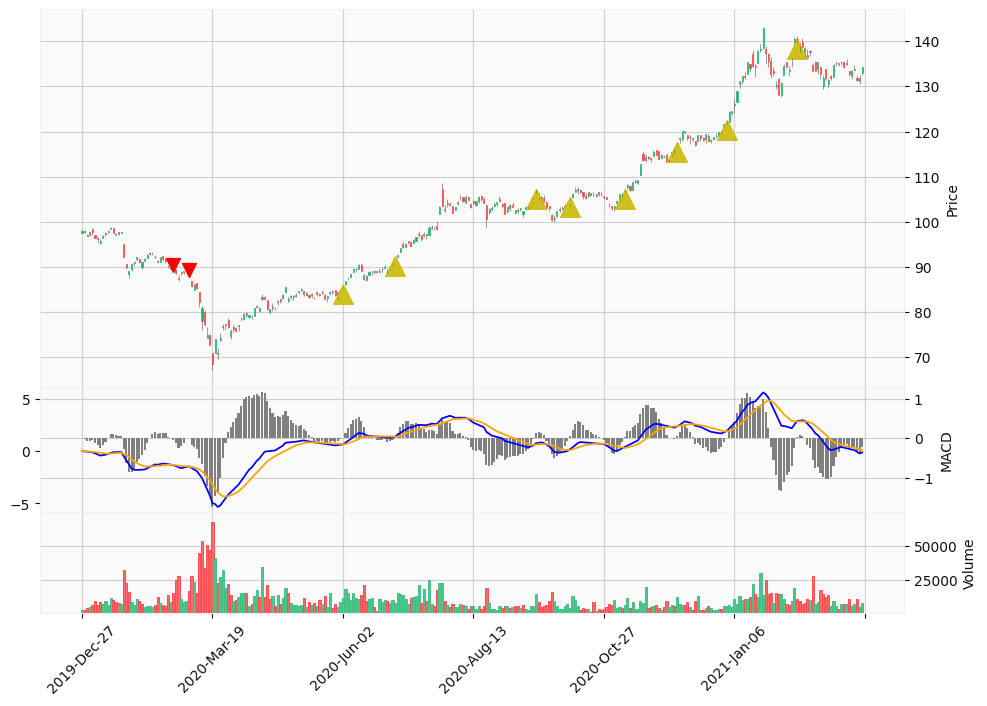

In [25]:
plots = []

# the position in graph
buy, sell = [], []

# Adjust the position to avoid signals block the lines
for index, row in data.iterrows():
    buy.append(row['Close']*0.985 if strategy_1.loc[index]['buy'] else np.nan)
    sell.append(row['Close']*1.01 if strategy_1.loc[index]['sell'] else np.nan)


plots = [
          mpf.make_addplot(data['macd_BAR'], type = 'bar', panel = 1, color = 'grey', ylabel = 'MACD'),
          mpf.make_addplot(data['macd_DIF'], panel = 1, color = 'blue'),
          mpf.make_addplot(data['macd_DEM'], panel = 1, color = 'orange'),
       ]

# Add trading point to plot
#    np.isnan(sell) determine the value is nan or not
#    count_nonzero(np.isnan(sell)) counts how many nan we have
#    if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

# # make the graph(plot)
mpf.plot(data,
         type='candle',   # candlestick chart of stock price
         volume=True,     # plots trading volume as well
         volume_panel=2,
         figscale=1.5,
         addplot = plots,
         style='yahoo', 
         panel_ratios = (3, 1, 0.8)
)  

### 4.4 超買超賣區：回溯檢驗

In [30]:
# how many shares we hold, and the money balance
have_shares , balance = 0, 0

# multiple buy and 1 sell as "a trade"
# record trading times and how many trade are making money
make_money, trade_times = 0, 0

# we use geometic average
# this is products of return rate
return_rate = 1
for index, row in data.iterrows():
    
    if(strategy_1.loc[index]['buy'] == 1):
        balance -= row['Close']
        have_shares += 1
        print('buy ', row['Close'])
    
    # sell signal or it reach ends
    elif((strategy_1.loc[index]['sell'] == 1 or index == data.index.values[-1])and
    # and we have some shares
          have_shares != 0):
        
        
        print('sell', row['Close'], "*" , have_shares)
        
        principal = -balance
        balance += row['Close'] * have_shares
        
        # to calculate accuracy
        trade_times += 1
        if(balance > 0):
            make_money += 1
            
        # plus 1 avoiding get too small
        return_rate *= 1+(balance / principal)
        
        # reset balance & shares
        balance = 0
        have_shares = 0
      

print()
print('cumulative return rate :', (return_rate-1) * 100, '%')
if(trade_times != 0):
    print('accuracy :', make_money/ trade_times * 100, '%')

buy  85.3
buy  91.5
buy  106.55
buy  104.8
buy  106.7
buy  117.3
buy  122.25
buy  140.35
sell 134.35 * 8

cumulative return rate : 22.869391254644178 %
accuracy : 100.0 %


## 5. 策略2：



買入：RSI在50以上停留6日可買入  
賣出：RSI在50以下停留6日可賣出


### 5.2 拉回不破：策略買賣信號

In [73]:
# initialize 'buy' & 'sell' column by filling with 0
strategy_2 = pd.DataFrame(index=ticker.index)
strategy_2['buy'] = np.zeros(ticker.shape[0])
strategy_2['sell'] = np.zeros(ticker.shape[0])


trading_interval = 6
trading_cooldown = trading_interval
stagnant_upper, stagnant_lower = 0, 0


# skip first RSI_n days
for i in range(RSI_n, data.shape[0]):
    
    trading_cooldown += 1
    # 在 upperbound 以上的話， counter就加一
    # 否則counter歸零
    if(data['RSI'][i] >= middle_line):
        stagnant_upper += 1
    else:
        stagnant_upper = 0

    # 在 lowerbound 以下的話， counter就加一
    # 否則counter歸零
    if(data['RSI'][i] <= middle_line ):
        stagnant_lower += 1
    else:
        stagnant_lower = 0
     
    if(stagnant_upper > trading_interval and trading_cooldown > trading_interval):
        trading_cooldown = 0
        strategy_2.loc[(data.index[i], 'buy')] = 1
        print('buy  |', data.index[i], data['Close'][i])
        
    if(stagnant_lower > trading_interval and trading_cooldown > trading_interval):
        trading_cooldown = 0
        strategy_2.loc[(data.index[i], 'sell')] = 1
        print('sell |', data.index[i], data['Close'][i])
    
    

sell | 2020-02-04 00:00:00 90.6
buy  | 2020-02-17 00:00:00 92.3
sell | 2020-03-16 00:00:00 77.3
sell | 2020-03-25 00:00:00 76.85
buy  | 2020-04-20 00:00:00 83.0
buy  | 2020-05-08 00:00:00 84.35
sell | 2020-05-22 00:00:00 82.95
buy  | 2020-06-09 00:00:00 89.6
buy  | 2020-07-08 00:00:00 95.15
sell | 2020-08-05 00:00:00 104.3
sell | 2020-08-26 00:00:00 104.3
buy  | 2020-09-16 00:00:00 106.55
sell | 2020-09-30 00:00:00 103.0
buy  | 2020-10-15 00:00:00 105.7
buy  | 2020-11-12 00:00:00 108.8
buy  | 2020-11-23 00:00:00 115.45
sell | 2020-12-02 00:00:00 115.4
buy  | 2020-12-11 00:00:00 118.75
buy  | 2021-01-05 00:00:00 124.6
buy  | 2021-01-14 00:00:00 134.05
sell | 2021-03-08 00:00:00 131.85
buy  | 2021-03-18 00:00:00 134.9


### 5.3 拉回不破：繪製交易點

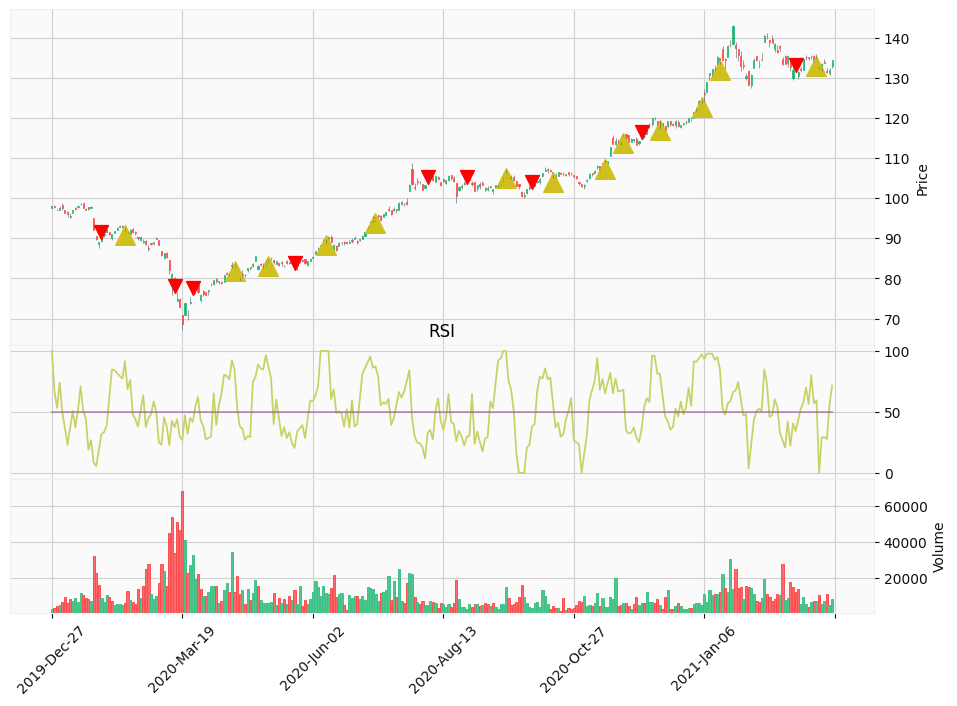

In [74]:
plots = []

# the position in graph
buy, sell = [], []

# Adjust the position to avoid signals block the lines
for index, row in data.iterrows():
    buy.append(row['Close']*0.985 if strategy_2.loc[index]['buy'] else np.nan)
    sell.append(row['Close']*1.01 if strategy_2.loc[index]['sell'] else np.nan)


plots = [ 
    # Add the RSI indicator to plot
    mpf.make_addplot(data['RSI'], panel = 1, color='#c8d164', title='RSI'),
    
    
    # Add middle_line to plot
    mpf.make_addplot(np.full((len(data)), middle_line), panel = 1, color='#7e3696', alpha=0.5),
]

# Add trading point to plot
#    np.isnan(sell) determine the value is nan or not
#    count_nonzero(np.isnan(sell)) counts how many nan we have
#    if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

mpf.plot( data, 
            type='candle',       # candlestick chart of stock price
            volume=True,         # plots trading volume as well
            volume_panel=2,
            figscale=1.5,          # make graph twice bigger
            style='yahoo',       # color scheme using 'yahoo' style
            addplot = plots,
)    

### 5.4 中線：回溯檢驗

In [75]:
# how many shares we hold, and the money balance
have_shares , balance = 0, 0

# multiple buy and 1 sell as "a trade"
# record trading times and how many trade are making money
make_money, trade_times = 0, 0

# we use geometic average
# this is products of return rate
return_rate = 1
for index, row in data.iterrows():
    
    if(strategy_2.loc[index]['buy'] == 1):
        balance -= row['Close']
        have_shares += 1
        print('buy ', row['Close'])
    
    # sell signal and we have some shares
    elif(strategy_2.loc[index]['sell'] == 1 and have_shares != 0):
        
        
        print('sell', row['Close'], "*" , have_shares)
        
        principal = -balance
        balance += row['Close'] * have_shares
        
        # to calculate accuracy
        trade_times += 1
        if(balance > 0):
            make_money += 1
            
        # plus 1 avoiding get too small
        return_rate *= 1+(balance / principal)
        
        # reset balance & shares
        balance = 0
        have_shares = 0
      

print()
print('cumulative return rate :', (return_rate-1) * 100, '%')
if(trade_times != 0):
    print('accuracy :', make_money/ trade_times * 100, '%')

buy  92.3
sell 77.3 * 1
buy  83.0
buy  84.35
sell 82.95 * 2
buy  89.6
buy  95.15
sell 104.3 * 2
buy  106.55
sell 103.0 * 1
buy  105.7
buy  108.8
buy  115.45
sell 115.4 * 3
buy  118.75
buy  124.6
buy  134.05
sell 131.85 * 3
buy  134.9

cumulative return rate : -0.3469687182913739 %
accuracy : 50.0 %


---
Other reference：

